# Deep Learning

## HW2- Problem 1 - neural net from (almost) scratch

1.   Full Name: Mohammad Kalbasi
2.   Student Number: 401211028

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Part A)Adding dataset and showing some samples

In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
WW = torch.tensor([[1,2],[4,5]],dtype = torch.float32)
WW.requires_grad_()
WW.requires_grad

True

In [ ]:
output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

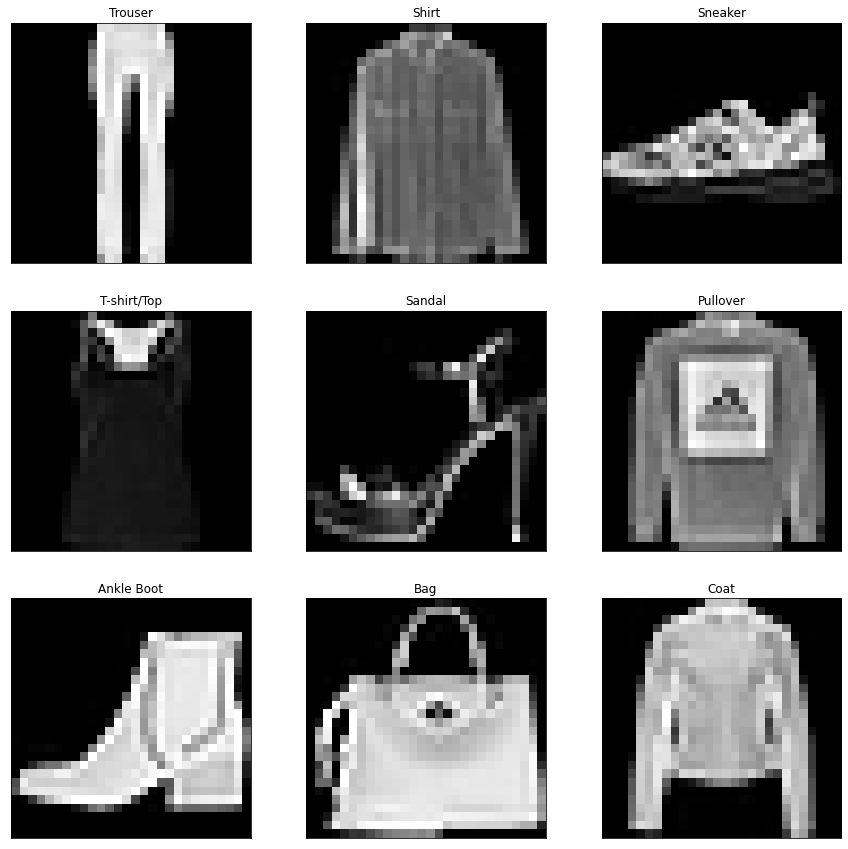

In [ ]:
labels_selected = []
fig = plt.figure(figsize = (15,15))
for idx in range(9):
  random_number = np.random.randint(0,len(train_data))
  X_temp,y_temp = train_data[random_number]
  y_temp = torch.argmax(y_temp).numpy()
  while(y_temp in labels_selected):
    random_number = np.random.randint(0,len(train_data))
    X_temp,y_temp = train_data[random_number]
    y_temp = torch.argmax(y_temp).numpy()
  labels_selected.append(y_temp)
  X_temp = X_temp.numpy()
  ax = fig.add_subplot(3,3,idx + 1,xticks = [],yticks = [])
  ax.imshow(np.squeeze(X_temp),cmap = 'gray')
  ax.set_title(output_mapping[int(y_temp)])



In [ ]:
def splitter(data):
  """
  function for splitting pytorch dataset to images and labels(we also resize images here)
  input:
    data: loaded data with pytorch library
  output:
    X: image data(reshaped to be a vector)
    y:labels(targets)
  """
  
  image_sample,label_sample = data[0]
  _,m,n = image_sample.size()
  m = int(m)
  n = int(n)
  w,= label_sample.size()
  w = int(w)
  X = torch.zeros((int(m*n),int(len(data))),dtype=torch.float32,device = device )
  y = torch.zeros((int(w),int(len(data))),dtype=torch.float32,device = device)
  for i in range(len(data)):
    im_temp,label_temp = data[i]
    im_temp = im_temp.resize(m*n)
    X[:,i] = im_temp
    y[:,i] = label_temp
  return X,y



In [ ]:
# splitting data
X_train,y_train = splitter(train_data)
X_test,y_test = splitter(test_data)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


part B) defining model parts

In [ ]:
def relu_manual(X):
  """
  manual implementation of relu function
  input:
    X:input,each coloumn is output for one sample
  output:
    z:output of function
  """
  z = X - torch.minimum(X,torch.zeros_like(X))
  
  return z

In [ ]:
def softmax_manual(X):
  """
  manual function for implementing softmax
  input:
    X:input, each coloumn is seperate data
  output:
    y
  """
  
  m,_ = X.size()
  m = int(m)
  x_max = (torch.max(X,axis = 0)).values
  X = X - x_max #adding value doesn't have effect on softmax output but it helpd to stablaize our values!(because it is ways easier to comput exp(-145) compare to exp(145)! one is near zero and one is very big number that we can't store in memory)
  exp_X = torch.exp(X)
  exp_X_sum = torch.sum(exp_X,axis = 0)
  exp_X_sum_rep = exp_X_sum.repeat(m,1)
  y = exp_X/exp_X_sum_rep
  return y


In [ ]:
def cross_entropy_manual(y,yp):
  """
  manual function for calculating multi class cross entropy loss
  input:
    y: ground truth label (each coloumn for each sample)
    yp = predicted label
  output:
    loss:calculated loss
  
  """
  epsilon =  1e-10 # adding to our test values to solve problem of calculating log of zero!
  log_part = torch.log(yp+epsilon)
  all_error = -1*y*log_part
  loss = torch.sum(all_error,axis = 0).mean()
  return loss


In [ ]:
def model(X,W1,W2,W3,W4,b1,b2,b3,b4):
  """
  our neural net model
  first we check how many layers we have based on that we define model 
  output create predicted labels 
  we assume that all hidden layer activation function should be relu and output activation function should be softmax
  input:
    X:input data, each coloumn if for a sample
  output:
    yp:predicted output
  """
  if (n_model == 3):
    yp = softmax_manual(0.1*W2@relu_manual(0.1*W1@X+b1)+b2) # nlp with 3 layer
    # we multiplied W with 0.1 because when we initialize values and multiply with our input the values became so high that network is in saturation state so we solve this problem with manually lower their values!(for some reason when you define W you can't define it like 0.1*rand directly so we use this method)
  if(n_model == 4):
   # yp = softmax_manual(0.1*W3@relu_manual(0.1*W2@relu_manual(0.1*W1@X+b1)+b2) + b3) # nlp with 4 layer
   yp = softmax_manual(W3@relu_manual(W2@relu_manual(W1@X+b1)+b2) + b3) # nlp with 4 layer
  if(n_model == 5):
    yp = softmax_manual(0.1*W4@relu_manual(0.1*W3@relu_manual(0.1*W2@relu_manual(0.1*W1@X+b1)+b2) + b3) + b4) # nlp with 4 layer
  return yp


In [ ]:
def accuracy_manual(y,yp):
  """
  function for calculating accuracy
  input:
    y: true labels
    yp:predicted labels
  output:
    acc = accuracy
  """
  y_labels = torch.argmax(y,axis = 0)
  yp_labels = torch.argmax(yp,axis = 0)
  acc = torch.sum(y_labels == yp_labels)/len(y_labels)
  return acc


In [ ]:
# now optimizing model
n_epochs = 100
batch_size = 8
learning_rate = 0.001
train_error = []
test_error = []
train_acc = []
test_acc = []


# defining parameters,we belive that we should use all 5 layers to achive best result
n_model = 4
input_node = 28*28 #number of nodes in each sample input
first_layer_nodes = 64 #number of hidden layer units
second_layer_nodes = 64
third_layer_nodes = 64
output = 10 #output neurons

W1 = 0.1*torch.rand(first_layer_nodes,input_node,dtype=torch.float32,device = device)
W1.requires_grad_()
b1 = torch.rand(first_layer_nodes,1,dtype=torch.float32,device = device,requires_grad=True)

W2 = 0.1*torch.rand(second_layer_nodes,first_layer_nodes,dtype=torch.float32,device = device)
W2.requires_grad_()
b2 = torch.rand(second_layer_nodes,1,dtype=torch.float32,device = device,requires_grad=True)

W4 = 0.1*torch.rand(third_layer_nodes,second_layer_nodes,dtype=torch.float32,device = device)
W4.requires_grad_()
b4 = torch.rand(third_layer_nodes,1,dtype=torch.float32,device = device,requires_grad=True)


W3 = 0.1*torch.rand(output,second_layer_nodes,dtype=torch.float32,device = device)
W3.requires_grad_()
b3 = torch.rand(output,1,dtype=torch.float32,device = device,requires_grad=True)




# Part C: training model
for epoch in range(n_epochs):

  permutation = torch.randperm(X_train.size()[1])

  for i in range(0,X_train.size()[1], batch_size):
        

    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[:,indices], y_train[:,indices]

    # in case you wanted a semi-full example
    yp = model(batch_x,W1,W2,W3,W4,b1,b2,b3,b4)
    loss = cross_entropy_manual(batch_y,yp)
    loss.backward()
    with torch.no_grad():
      W1 -= learning_rate * W1.grad
      W2 -= learning_rate * W2.grad
      W3 -= learning_rate * W3.grad
      #W4 -= learning_rate * W4.grad


      b1 -= learning_rate * b1.grad
      b2 -= learning_rate * b2.grad
      b3 -= learning_rate * b3.grad
      #b4 -= learning_rate * b4.grad

      # zero the gradients after updating
      W1.grad.zero_()
      W2.grad.zero_()
      W3.grad.zero_()
      #W4.grad.zero_()

      b1.grad.zero_()
      b2.grad.zero_()
      b3.grad.zero_()
      #b4.grad.zero_()
  train_out = model(X_train,W1,W2,W3,W4,b1,b2,b3,b4)
  train_error.append(cross_entropy_manual(y_train,train_out))
  train_acc.append(accuracy_manual(y_train,train_out))

  test_out = model(X_test,W1,W2,W3,W4,b1,b2,b3,b4)
  test_error.append(cross_entropy_manual(y_test,test_out))
  test_acc.append(accuracy_manual(y_test,test_out))
  
  print(f"Epoch: {epoch} | Accuracy:{train_acc[epoch]:.5f} | Loss: {train_error[epoch]:.5f}| Test Accuracy:{test_acc[epoch]:.5f} | Test Loss: {test_error[epoch]:.5f}") 

  

        



        

Epoch: 0 | Accuracy:0.10000 | Loss: 19.85784| Test Accuracy:0.10000 | Test Loss: 19.87853
Epoch: 1 | Accuracy:0.53472 | Loss: 1.17730| Test Accuracy:0.53360 | Test Loss: 1.17774
Epoch: 2 | Accuracy:0.65040 | Loss: 0.91701| Test Accuracy:0.65220 | Test Loss: 0.91765
Epoch: 3 | Accuracy:0.71017 | Loss: 0.76941| Test Accuracy:0.70740 | Test Loss: 0.77948
Epoch: 4 | Accuracy:0.75098 | Loss: 0.67654| Test Accuracy:0.74470 | Test Loss: 0.69384
Epoch: 5 | Accuracy:0.76078 | Loss: 0.64238| Test Accuracy:0.74680 | Test Loss: 0.66389
Epoch: 6 | Accuracy:0.76377 | Loss: 0.65241| Test Accuracy:0.75780 | Test Loss: 0.67224
Epoch: 7 | Accuracy:0.78298 | Loss: 0.58662| Test Accuracy:0.77300 | Test Loss: 0.60764
Epoch: 8 | Accuracy:0.79497 | Loss: 0.55773| Test Accuracy:0.78230 | Test Loss: 0.57848
Epoch: 9 | Accuracy:0.79805 | Loss: 0.55706| Test Accuracy:0.78850 | Test Loss: 0.57890
Epoch: 10 | Accuracy:0.80732 | Loss: 0.53127| Test Accuracy:0.79090 | Test Loss: 0.55772
Epoch: 11 | Accuracy:0.81878 

In [ ]:
print(f"accuracy on test data = {test_acc[len(test_acc)-1]}")

accuracy on test data = 0.8621000051498413


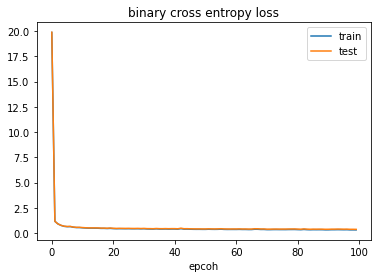

In [ ]:
# plotting loss and accuracy
train_error_float = []
test_error_float = []
for i in range(len(train_error)):
  train_error_float.append(float(train_error[i]))
  test_error_float.append(float(test_error[i]))
plt.plot(train_error_float)
plt.plot(test_error_float)
plt.title('binary cross entropy loss')
plt.xlabel('epcoh')
plt.legend(['train','test'])
plt.show()


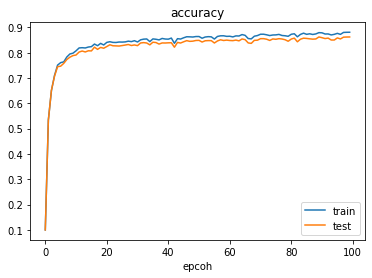

In [ ]:
# plotting loss and accuracy
train_acc_float = []
test_acc_float = []
for i in range(len(train_error)):
  train_acc_float.append(float(train_acc[i]))
  test_acc_float.append(float(test_acc[i]))
plt.plot(train_acc_float)
plt.plot(test_acc_float)
plt.title('accuracy')
plt.xlabel('epcoh')
plt.legend(['train','test'])
plt.show()


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


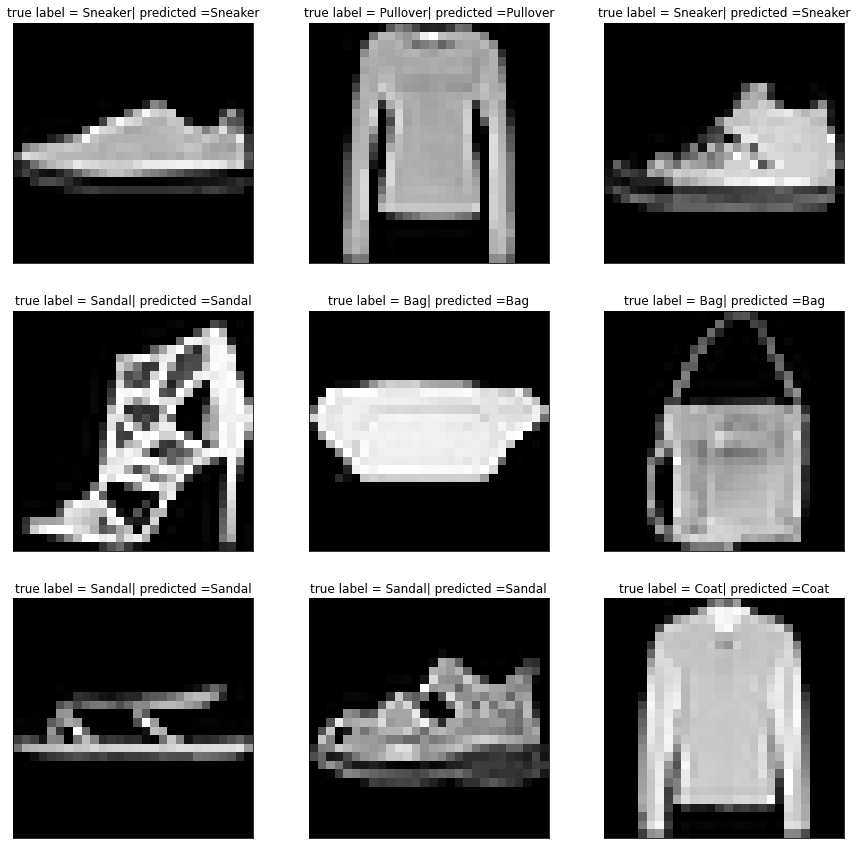

In [ ]:
labels_selected = []
fig = plt.figure(figsize = (15,15))
for idx in range(9):
  random_number = np.random.randint(0,len(test_data))
  X_temp,y_temp = test_data[random_number]
  
  X_temp_model = X_test[:,random_number]
  X_temp_model = X_temp_model.resize(784,1)
  yp = model(X_temp_model,W1,W2,W3,W4,b1,b2,b3,b4)
  y_temp = torch.argmax(y_temp).numpy()
  yp_temp = torch.argmax(yp) # predicted output as label(and not one hot form!)
  labels_selected.append(y_temp)
  X_temp = X_temp.numpy()
  ax = fig.add_subplot(3,3,idx + 1,xticks = [],yticks = [])
  ax.imshow(np.squeeze(X_temp),cmap = 'gray')
  text = "true label = " + output_mapping[int(y_temp)] + "| predicted =" + output_mapping[int(yp_temp)]
  ax.set_title(text)


The results are pretty good!